## ***Dask for Machine Learning***
Visit the main Dask-ML documentation: https://examples.dask.org/machine-learning/

<br>

**Why Dask?** <br>
Pandas and NumPy are great libraries, but when it comes to large datasets, they are inefficient because they take longer to compute than smaller datasets. This is where Dask comes in. The first step to understanding Dask is to know one of the key features that sets Dask apart from the competition is that it is entirely written and implemented in Python. ***The collection APIs of Dask is designed to scale NumPy, pandas, and scikit-learn natively. It uses parallel and distributed computing to overcome the limits of a single machine.***

## ***Dask Interfaces***

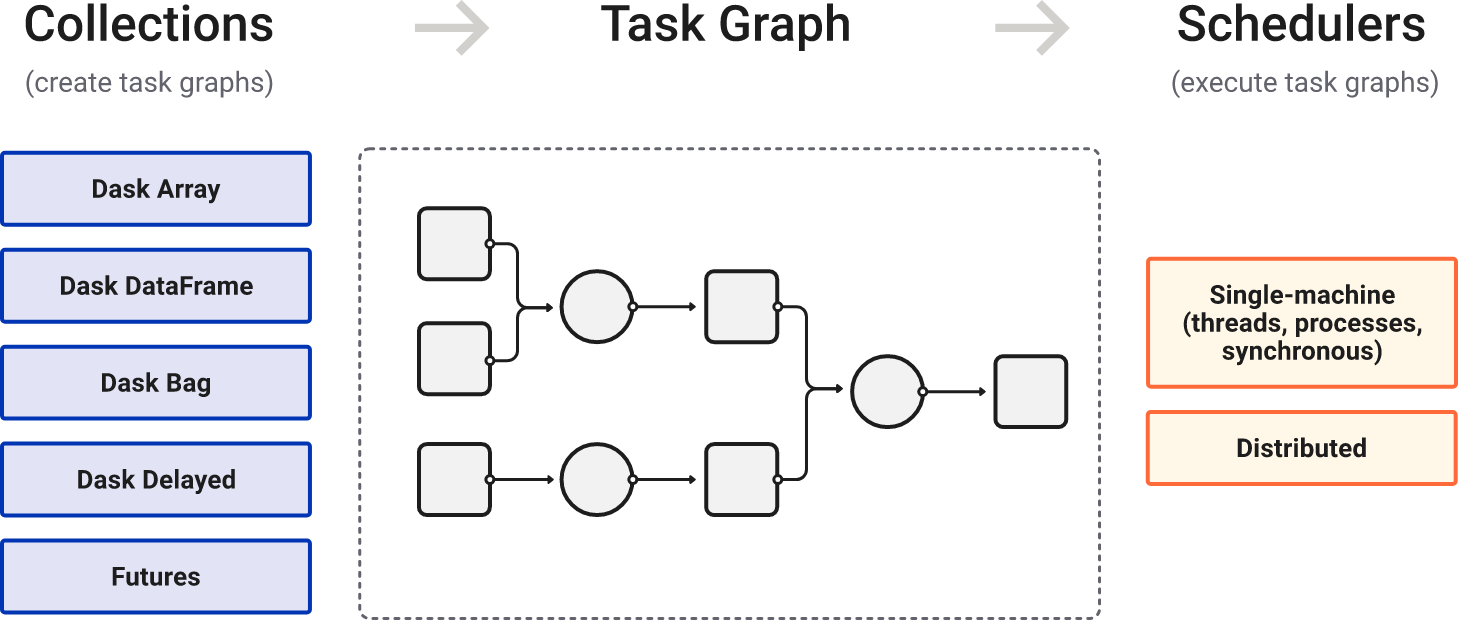

Install the necessary libraries before using/importing them

In [ ]:
# Install everything
!python -m pip install "dask[complete]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## ***Train Models on Large Datasets***

* Most estimators in scikit-learn are designed to work with NumPy arrays or scipy sparse matricies. These data structures must fit in the RAM on a single machine.

* Estimators implemented in Dask-ML work well with Dask Arrays and DataFrames. This can be much larger than a single machine’s RAM. They can be distributed in memory on a cluster of machines.

In [ ]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at: inproc://172.28.0.12/1574/1
INFO:distributed.scheduler:  dashboard at:            localhost:8787
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-worker-space/worker-jb86h46x', purging
INFO:distributed.worker:      Start worker at: inproc://172.28.0.12/1574/4
INFO:distributed.worker:         Listening to:          inproc172.28.0.12
INFO:distributed.worker:          Worker name:                          0
INFO:distributed.worker:         dashboard at:          172.28.0.12:38661
INFO:distributed.worker:Waiting to connect to: inproc://172.28.0.12/1574/1
INFO:distributed.worker:-------------------------------------------------
INFO:distributed.worker:              Threads:                          4
INFO:distributed.worker:             

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.28.0.12:8787/status,
Dashboard: http://172.28.0.12:8787/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://172.28.0.12/1574/1,Workers: 1
Dashboard: http://172.28.0.12:8787/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: inproc://172.28.0.12/1574/4,Total threads: 4
Dashboard: http://172.28.0.12:38661/status,Memory: 1.86 GiB
Nanny: None,


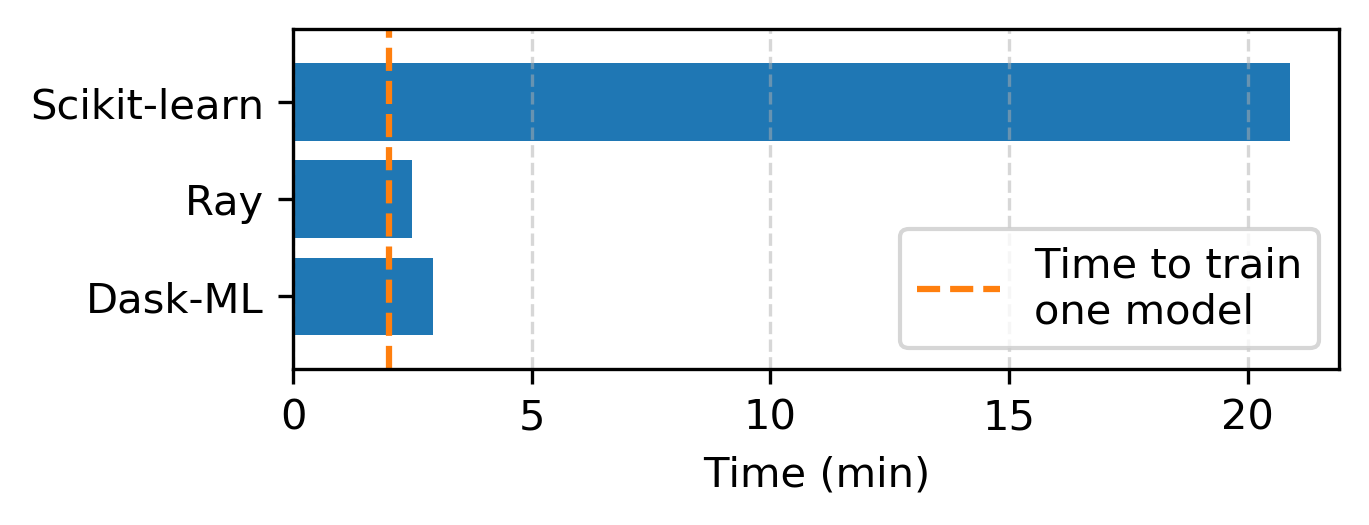

***Methodology:***

* Scikit-learn uses joblib for single-machine parallelism. This lets you train most estimators (anything that accepts an n_jobs parameter) using all the cores of your laptop or workstation.

* Alternatively, Scikit-Learn can use Dask for parallelism. This lets you train those estimators using all the cores of your cluster without significantly changing your code.

* This is most useful for training large models on medium-sized datasets. You may have a large model when searching over many hyper-parameters, or when using an ensemble method with many individual estimators. For too small datasets, training times will typically be small enough that cluster-wide parallelism isn't helpful. For too large datasets (larger than a single machine's memory), the scikit-learn estimators may not be able to cope (see below).

### ***Importing necessary libraries:***

In [ ]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

### ***Taking a small sample to test the show the normal flow***

In [ ]:
X, y = make_classification(n_samples=1000, random_state=0)
df = X[:5]
print(df)

[[-1.06377997  0.67640868  1.06935647 -0.21758002  0.46021477 -0.39916689
  -0.07918751  1.20938491 -0.78531472 -0.17218611 -1.08535744 -0.99311895
   0.30693511  0.06405769 -1.0542328  -0.52749607 -0.0741832  -0.35562842
   1.05721416 -0.90259159]
 [ 0.0708476  -1.69528125  2.44944917 -0.5304942  -0.93296221  2.86520354
   2.43572851 -1.61850016  1.30071691  0.34840246  0.54493439  0.22532411
   0.60556322 -0.19210097 -0.06802699  0.9716812  -1.79204799  0.01708348
  -0.37566904 -0.62323644]
 [ 0.94028404 -0.49214582  0.67795602 -0.22775445  1.40175261  1.23165333
  -0.77746425  0.01561602  1.33171299  1.08477266 -0.97805157 -0.05012039
   0.94838552 -0.17342825 -0.47767184  0.76089649  1.00115812 -0.06946407
   1.35904607 -1.18958963]
 [-0.29951677  0.75988955  0.18280267 -1.55023271  0.33821802  0.36324148
  -2.10052547 -0.4380675  -0.16639343 -0.34083531  0.42435643  1.17872434
   2.8314804   0.14241375 -0.20281911  2.40571546  0.31330473  0.40435568
  -0.28754632 -2.8478034 ]
 [-2

### ***Setting the Hyperparameters for GridSearchCV using SVC***

In [ ]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           cv=3,
                           n_jobs=-1)

In [ ]:
import joblib

with joblib.parallel_backend('dask'):
    grid_search.fit(X, y)

Exception ignored in: <function _WeakKeyDictionary.__setitem__.<locals>.on_destroy at 0x7fdded8b01f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/joblib/_dask.py", line 80, in on_destroy
    del self._data[key]
KeyError: 140591150200464


### ***GridSearchCV Results***

We fit 48 different models, one for each hyper-parameter combination in param_grid , distributed across the cluster. At this point, we have a regular scikit-learn model, which can be used for prediction, scoring, etc.

In [ ]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_shrinking,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.655017,0.048081,0.091932,0.001374,0.001,rbf,True,"{'C': 0.001, 'kernel': 'rbf', 'shrinking': True}",0.502994,0.501502,0.501502,0.501999,0.000704,41
1,0.648366,0.072582,0.090608,0.004904,0.001,rbf,False,"{'C': 0.001, 'kernel': 'rbf', 'shrinking': False}",0.502994,0.501502,0.501502,0.501999,0.000704,41
2,0.490789,0.044229,0.038055,0.010205,0.001,poly,True,"{'C': 0.001, 'kernel': 'poly', 'shrinking': True}",0.502994,0.501502,0.501502,0.501999,0.000704,41
3,0.420599,0.009181,0.027800,0.005315,0.001,poly,False,"{'C': 0.001, 'kernel': 'poly', 'shrinking': Fa...",0.502994,0.501502,0.501502,0.501999,0.000704,41
4,0.472032,0.020386,0.050640,0.008283,0.001,sigmoid,True,"{'C': 0.001, 'kernel': 'sigmoid', 'shrinking':...",0.502994,0.501502,0.501502,0.501999,0.000704,41


### ***GridSearhCV Score***

In [ ]:
pd.DataFrame(grid_search.cv_results_).head()
grid_search.predict(X)[:5]
grid_search.score(X, y)

0.983

In [ ]:
%matplotlib inline

In [ ]:
!pip install dask-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


***We’ll use dask_ml.datasets.make_blobs to generate some random dask arrays***

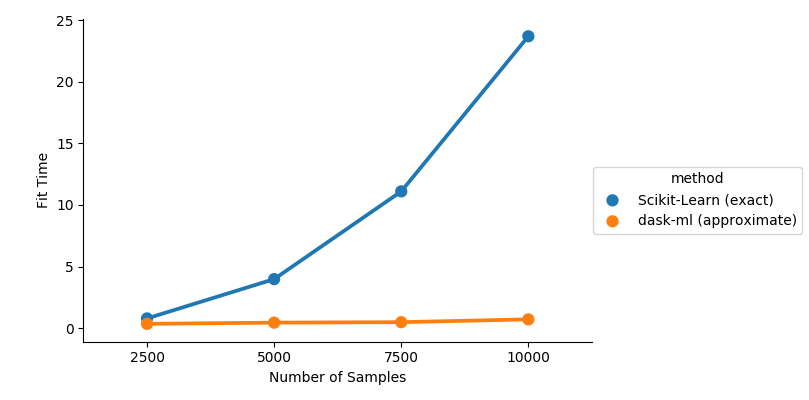

In [ ]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In [ ]:
X, y = dask_ml.datasets.make_blobs(n_samples=10000000,
                                   n_features=100,
                                   chunks=1000000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

2023-03-20 12:41:02,513 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.39 GiB -- Worker memory limit: 1.86 GiB
2023-03-20 12:41:02,613 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.32 GiB -- Worker memory limit: 1.86 GiB
2023-03-20 12:41:02,943 - distributed.worker.memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 1.55 GiB -- Worker memory limit: 1.86 GiB
2023-03-20 12:41:02,946 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory lea

dask.array<concatenate, shape=(10000000, 100), dtype=float64, chunksize=(1000000, 100), chunktype=numpy.ndarray>

***We’ll use the k-means implemented in Dask-ML to cluster the points. It uses the k-means|| (read: “k-means parallel”) initialization algorithm, which scales better than k-means++. All of the computation, both during and after initialization, can be done in parallel***

In [ ]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

2023-03-20 12:41:08,813 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.31 GiB -- Worker memory limit: 1.86 GiB
2023-03-20 12:41:08,913 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.32 GiB -- Worker memory limit: 1.86 GiB
2023-03-20 12:41:09,013 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

KMeans(init_max_iter=2, n_clusters=3, oversampling_factor=10)

INFO:distributed.core:Event loop was unresponsive in Scheduler for 31.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Worker for 31.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 22.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Worker for 30.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 7.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can

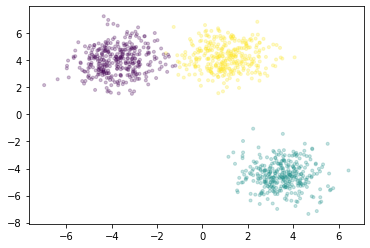

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

***Setting the memory limit to 4GB*** than the previous one **which was 2GB**

In [ ]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='4GB')
client

/usr/local/lib/python3.9/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44005 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at: inproc://172.28.0.12/1574/14
INFO:distributed.scheduler:  dashboard at:           localhost:44005
INFO:distributed.worker:      Start worker at: inproc://172.28.0.12/1574/17
INFO:distributed.worker:         Listening to:          inproc172.28.0.12
INFO:distributed.worker:          Worker name:                          0
INFO:distributed.worker:         dashboard at:          172.28.0.12:35067
INFO:distributed.worker:Waiting to connect to: inproc://172.28.0.12/1574/14
INFO:distributed.worker:-------------------------------------------------
INFO:distributed.worker:              Threads:                          4
INFO:distributed.worker:               Memory:                   3.73 GiB
INFO:distri

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.28.0.12:44005/status,
Dashboard: http://172.28.0.12:44005/status,Workers: 1
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: False
Comm: inproc://172.28.0.12/1574/14,Workers: 1
Dashboard: http://172.28.0.12:44005/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: inproc://172.28.0.12/1574/17,Total threads: 4
Dashboard: http://172.28.0.12:35067/status,Memory: 3.73 GiB
Nanny: None,


***We're increasing the dataset sample rows to 5,00,00,000 & no. of columns remains the same to 2***

In [ ]:
X, y = dask_ml.datasets.make_blobs(n_samples=50000000,
                                   chunks=1000000,
                                   random_state=0,
                                   centers=5)
X = X.persist()
X

dask.array<concatenate, shape=(50000000, 2), dtype=float64, chunksize=(1000000, 2), chunktype=numpy.ndarray>

**Used the k-means algo just like the previous one:**

In [ ]:
km = dask_ml.cluster.KMeans(n_clusters=5, init_max_iter=2, oversampling_factor=10)
km.fit(X)

2023-03-20 12:59:28,657 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.32 GiB -- Worker memory limit: 1.86 GiB
2023-03-20 12:59:28,767 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.32 GiB -- Worker memory limit: 1.86 GiB
2023-03-20 12:59:28,929 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

KMeans(init_max_iter=2, n_clusters=5, oversampling_factor=10)

2023-03-20 13:00:59,877 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.34 GiB -- Worker memory limit: 1.86 GiB
2023-03-20 13:00:59,965 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.34 GiB -- Worker memory limit: 1.86 GiB
2023-03-20 13:01:00,078 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

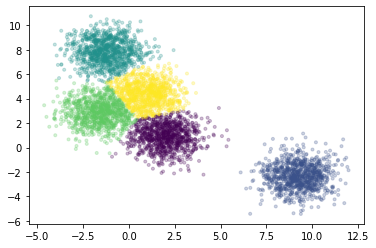

2023-03-20 13:01:07,215 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.34 GiB -- Worker memory limit: 1.86 GiB


In [ ]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

### ***`Conclusion`***

* Dask is a powerful library that provides parallel and distributed computing capabilities for large-scale data processing.
* With its various interfaces and compatibility with popular data science tools, Dask offers a convenient and efficient solution for working with big data. 
* In the end, readers should have a strong understanding Dask and its capabilities, as well as the knowledge and skills to implement a machine-learning project using Dask. 
* As the demand for big data processing continues to grow, the importance of tools like Dask will only increase, making it a valuable asset for anyone in the data science field.

**Name**:Shobhandeb Paul <br>
**Linkedin**: https://www.linkedin.com/in/shobhandeb-paul/ <br>
**Github:** https://github.com/herbert0419/